## 3.3. Bayesian Linear Regression

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-rc1

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import sys
import copy
import math
import matplotlib.pyplot as plt

     |████████████████████████████████| 380.5MB 15kB/s 
     |████████████████████████████████| 4.3MB 47.0MB/s 
     |████████████████████████████████| 501kB 61.9MB/s 


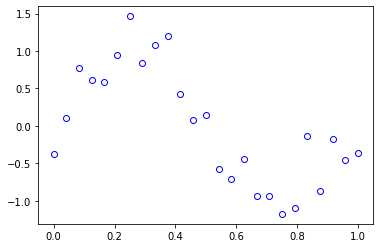

In [2]:
# 참고: https://github.com/ctgk/PRML

def sinusoidal(x):
  return tf.math.sin(2 * math.pi * x)

def linear(x):
  return -0.3 + 0.5 * x

def cubic(x):
  return x * (x - 5) * (x + 5)  

def create_toy_data(func, sample_size, std, domain=[0.0, 1.0]):
  x = tf.cast(tf.linspace(domain[0], domain[1], sample_size), tf.float64)
  x = tf.random.shuffle(x)
  t = func(x) + tf.random.normal(x.shape, stddev=std, dtype=tf.float64)
  return x, t

x, y = create_toy_data(sinusoidal, 25, 0.25)
plt.plot(x, y, 'bo', markerfacecolor='none')

In [3]:
def polynomial_basis_functions(x, M):
  X = []
  for i in range(M):
    X.append(tf.math.pow(x, i))
  return tf.cast(tf.transpose(tf.stack(X)), tf.float64)

print(polynomial_basis_functions(0.5, 4))
print(polynomial_basis_functions([-0.5, 0.0, 0.5], 6))

tf.Tensor([1.    0.5   0.25  0.125], shape=(4,), dtype=float64)
tf.Tensor(
[[ 1.      -0.5      0.25    -0.125    0.0625  -0.03125]
 [ 1.       0.       0.       0.       0.       0.     ]
 [ 1.       0.5      0.25     0.125    0.0625   0.03125]], shape=(3, 6), dtype=float64)


In [4]:
def gaussian_basis_functions(x, mu, s):
  X = []
  for m in mu:
    X.append(
        tf.math.exp(-0.5 * tf.math.pow(tf.subtract(x, m), 2) / s**2)) # 식 3.4
  return tf.cast(tf.transpose(tf.stack(X)), tf.float64)

mu, s = tf.linspace(-1.0, 1.0, 6), 0.1
print(gaussian_basis_functions(0.5, mu, s))
print(gaussian_basis_functions([-0.5, 0.0, 0.5], mu, s).shape)

tf.Tensor(
[0.00000000e+00 5.31107191e-27 2.28973489e-11 1.11090122e-02
 6.06530488e-01 3.72665318e-06], shape=(6,), dtype=float64)
(3, 6)


In [5]:
def sigmoidal_basis_functions(x, mu, s):
  X = []
  for m in mu:
    X.append(
        tf.math.sigmoid(tf.subtract(x, m) / s)) # 식 3.5
  return tf.cast(tf.transpose(tf.stack(X)), tf.float64)

mu, s = tf.linspace(-1.0, 1.0, 6), 0.1
print(sigmoidal_basis_functions(0.5, mu, s))
print(sigmoidal_basis_functions([-0.5, 0.0, 0.5], mu, s).shape)

tf.Tensor([0.99999964 0.99998331 0.999089   0.95257413 0.26894137 0.00669285], shape=(6,), dtype=float64)
(3, 6)


In [0]:
class Gaussian:
  def __init__(self, mu=None, var=None):
    self.mu = mu
    self.var = var
    if mu is not None:
      assert self.check_parameter_mu(mu), "mu in R"
      self.mu = tf.cast(mu, tf.float64)
    if var is not None:
      assert self.check_parameter_var(var), "var > 0 and var.shape == mu.shape"
      self.var = tf.cast(var, tf.float64)
    
  def check_support(self, x):
    if tf.rank(x) == 0:
      return not isinstance(x, (tf.complex64, tf.complex128))
    else:
      return all(
          [not e.dtype in (tf.complex64, tf.complex128) for e in x])

  def check_parameter_mu(self, mu):
    if tf.rank(mu) == 0:
      return not isinstance(mu, (tf.complex64, tf.complex128))
    else:
      return all(
          [not e.dtype in (tf.complex64, tf.complex128) for e in mu])
  
  def check_parameter_var(self, var):
    if tf.rank(var) == 0:
      return var > 0
    else:
      return all([e > 0 for e in var]) and mu.shape == var.shape

  def mean(self):
    return self.mu
  
  def variance(self):
    return self.var

  def pdf(self, x):
    assert self.check_support(x), "x in R"
    mu = self.mu
    var = self.var
    x = tf.cast(x, tf.float64)

    d = tf.math.subtract(x, mu)
    return (tf.math.exp(-0.5 / var * d ** 2) / tf.math.sqrt(2 * math.pi * var))
  
  def mle(self, D):
    pass

In [0]:
class MultivariateGaussian:
  def __init__(self, mu=None, cov=None):
    self.mu = mu
    self.cov = cov
    if mu is not None and cov is not None:
      self.mu = tf.reshape(tf.cast(mu, tf.float64), shape=[-1, 1])
      self.D  = self.mu.shape[0]
      self.cov = tf.cast(cov, tf.float64)

  def mean(self):
    return tf.squeeze(self.mu)
  
  def covariance(self):
    return self.cov

  def pdf(self, x):
    mu = self.mu
    cov = self.cov
    
    x = tf.transpose(tf.cast(x, tf.float64))
    d = tf.math.subtract(x, mu)
    precision_mat = tf.linalg.inv(cov)
    return tf.squeeze(
      tf.linalg.diag_part(
        tf.math.exp(-0.5 * tf.matmul(
            tf.matmul(tf.transpose(d), precision_mat), d))
        / tf.math.sqrt(tf.linalg.det(cov))
        / tf.math.pow(tf.cast(2.0, tf.float64) * math.pi, 0.5 * self.D)))

  def mle(self, D):
    N = len(D)
    sample_mean = tf.reduce_mean(D, axis=0) # (식 2.122)
    self.mu = tf.reshape(sample_mean, shape=[-1, 1])
    D = tf.transpose(D)
    d = tf.subtract(D, self.mu)
    self.cov = (1/(N-1) * tf.matmul(d, tf.transpose(d))) # (식 2.125)

    return self.mean(), self.covariance()

  # TODO: np 제거
  def sample(self, sample_size):
    import numpy as np
    mu = tf.squeeze(self.mu)
    cov = self.cov
    return np.random.multivariate_normal(mu, cov, sample_size)

In [0]:
class BayesianRegression():
  def __init__(self, prior, beta=25.0):
    self.beta = beta
    self.prior = prior
    self.posterior = copy.deepcopy(prior)

  def train(self, X, t):
    self.prior = copy.deepcopy(self.posterior)

    prior_mean = self.prior.mean()
    prior_precision = tf.linalg.inv(self.prior.covariance())

    posterior_precision = tf.math.add(prior_precision,
      beta * tf.linalg.matmul(tf.transpose(X), X)) # 식 3,51

    posterior_covariance = tf.linalg.inv(posterior_precision)
    second_term = tf.math.add(
        tf.linalg.matvec(prior_precision, prior_mean), 
        beta * tf.linalg.matvec(tf.transpose(X), t))
    posterior_mean = tf.linalg.matvec(posterior_covariance, second_term)

    self.posterior = MultivariateGaussian(posterior_mean, posterior_covariance)
  
  def evaluate(self):
    pass

  def predict(self, X):
    return tf.linalg.matvec(X, self.posterior.mean) # 식 3.3
  
  # 식 3.3, 식 3.8
  def likelihood(self, phi, t, w):
    y_of_xw = tf.linalg.matvec(tf.cast(w, tf.float64), phi)
    beta = self.beta
    mean = y_of_xw
    cov = 1.0 / beta
    dist = Gaussian(mean, cov)
    return dist.pdf(t[0:1])

In [0]:
a0, a1 = -0.3, 0.5
alpha, beta = 2.0, 25.0
N = 20

prior = MultivariateGaussian([0.0, 0.0], (1.0/alpha)*tf.eye(2))
model = BayesianRegression(prior)

def linear(x):
  return a0 + a1 * x

x, t = create_toy_data(linear, N, tf.sqrt(1.0/beta).numpy(), [-1.0, 1.0])
x_plot = tf.linspace(-1.0, 1.0, 100)

In [0]:
M = 2
X = polynomial_basis_functions(x, M)
X_plot = polynomial_basis_functions(x_plot, M)

In [0]:
u1 = tf.linspace(-1.0, 1.0, num=100)
u2 = tf.linspace(-1.0, 1.0, num=100)
u_grid = tf.stack(tf.meshgrid(u1, u2), axis=-1)
u_grid = tf.reshape(u_grid, [-1, 2])

In [0]:
def train_bayesian_regression(model, data_range=None):
  if data_range is not None:
    begin, end = data_range
    model.train(X[begin:end], t[begin:end])

  posterior = model.posterior
  q0 = posterior.pdf(u_grid)
  
  plt.figure(figsize=(7,2))
  if data_range is not None:
    ax = plt.subplot(1, 3, 1)
    likelihood_vec = model.likelihood(X[end-1:end], t[end-1:end], u_grid)
    plt.hexbin(u_grid[:,0], u_grid[:,1], 
               C=tf.squeeze(likelihood_vec), cmap='jet')

  ax = plt.subplot(1, 3, 2)
  plt.hexbin(u_grid[:,0], u_grid[:,1], C=q0.numpy(), cmap='jet')
  plt.scatter(a0, a1, c='w', s=100, marker="+")
  plt.gca().set_aspect('equal')
  plt.xlim([-1, 1])
  plt.ylim([-1, 1])

  ax = plt.subplot(1, 3, 3)
  ws = posterior.sample(6)
  Y_plot = tf.linalg.matmul(X_plot, tf.transpose(ws))
  for i in range(6):
    plt.plot(x_plot, Y_plot[:,i], c="r")
  if data_range is not None:
    plt.plot(x[:end], t[:end], 'bo', markerfacecolor='none')
  plt.xlim(-1, 1)
  plt.ylim(-1, 1)
  plt.gca().set_aspect('equal')

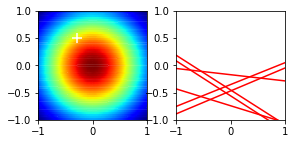

In [13]:
train_bayesian_regression(model)

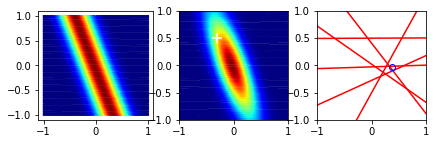

In [14]:
train_bayesian_regression(model, [0,1])

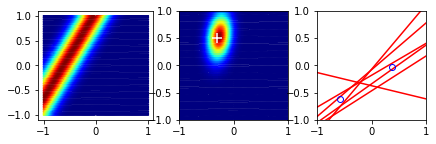

In [15]:
train_bayesian_regression(model, [1,2])

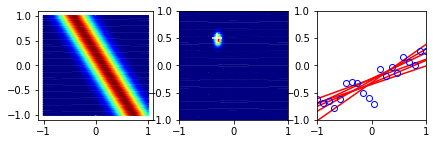

In [16]:
train_bayesian_regression(model, [2,20])